# Imports

In [36]:
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as stats
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Functions

In [37]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must not be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')
    plt.show()


def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df["x"].values[i: i + frame_size]  # [start seconds - start seconds + frame_size]
        y = df["y"].values[i: i + frame_size]
        z = df["z"].values[i: i + frame_size]

        # Retrieve the most frequent label in this segment
        label = df["label"].iloc[i: i + frame_size].mode()[0]  # Use .iloc for integer indexing
        frames.append([x, y, z])
        labels.append(label)

    # Convert lists to NumPy arrays
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

def plot_learningCurve(history, epochs):
  # Plotting the accuracy graph of training & validation
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Number of Epochs')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()

  # Plotting the loss graph of training & validation
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Number of Epochs')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()


def plot_activity(activity, data):
    fig, (axe, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)

    plot_axis(axe, data['timestamp'], data['x'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y'], 'Y-Axis')

    plot_axis(ax2, data['timestamp'], data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)

    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)

    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x,y,"r")
    ax.set_title(title)
    ax.xaxis.set_visible(False)

    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])

    ax.grid(True)

# Data

## Read data from file into pandas dataframe

In [38]:
file = open("WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt")  # Dataset (your file path here)
lines = file.readlines()

processedData = []  # Dataset after processing, it is necessary in order to exclude incorrectly formatted data

for i, line in enumerate(lines):
    try:
        line = line.split(",")
        last = line[5].split(";")[0]
        last = last.strip()
        if last == "":
            break
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedData.append(temp)
    except:
        print("Error in line: ", i)

columns = ["user","activity", "timestamp", "x", "y", "z"]
data = pd.DataFrame(data = processedData, columns = columns)

Error in line:  281873
Error in line:  281874
Error in line:  281875


In [39]:
data.head(5) # First 5 rows of our dataset

,user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [40]:
data.shape # Shape of the dataset, in our case it's 343416 rows and 6 columns

(343416, 6)

In [41]:
data.isnull().sum() # To check if any value is null, in our case there are none

user         0
activity     0
timestamp    0
x            0
y            0
z            0
dtype: int64

In [42]:
data["activity"].value_counts()

activity
Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: count, dtype: int64

Chosen dataset is very unbalanced (for detailed info check the about file in the dataset folder). 
This line displays how many occurrences of each activity are present within our dataset.
If used just as provided, our model would be overfitted with certain activities and would heavily.
lean towards walking and jogging which most likely would produce incorrect results when trying to use it.

## Data balancing

The model needs data as numbers and currently they are strings so we need to convert them to floats

In [43]:
data["x"] = data["x"].astype(float)
data["y"] = data["y"].astype(float)
data["z"] = data["z"].astype(float)

In [44]:
df = data.drop(["user", "timestamp"], axis = 1).copy()  # The only important data. User id and timestamp are not relevant so we drop them

In [45]:
df.head(5)

,activity,x,y,z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


Now we ensure same number of entries is used across all activities

In [46]:
Walking = df[df["activity"] == "Walking"].head(3555).copy()
Jogging = df[df["activity"] == "Jogging"].head(3555).copy()
Upstairs = df[df["activity"] == "Upstairs"].head(3555).copy()
Downstairs = df[df["activity"] == "Downstairs"].head(3555).copy()
Sitting = df[df["activity"] == "Sitting"].head(3555).copy()
Standing = df[df["activity"] == "Standing"].copy()

With the code above only first 3555 entries were taken into the account as it is the number of entries in the smalles set of data. Now everything can be stiched back together again.

In [47]:
balanced_data = pd.concat([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])

balanced_data.shape

In [48]:
balanced_data['activity'].value_counts()

activity
Walking       3555
Jogging       3555
Upstairs      3555
Downstairs    3555
Sitting       3555
Standing      3555
Name: count, dtype: int64

In [49]:
label = LabelEncoder()
balanced_data["label"] = label.fit_transform(balanced_data["activity"])  # categorises activities

In [50]:
X = balanced_data[["x","y","z"]]
y = balanced_data["label"]

## Data normalization

It is important to ensure that used data is normalized for the best results

In [51]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data=X, columns=["x","y","z"])
scaled_X["label"] = y.values

## Final data preparation

For best results we cannot use single entry in our dataset for predictions. 
This is due to fact that each entry was taken at frequency of 20 Hz which is too much to make any accurate prediction.
We need to average out some amount of entries in specified amount of time as one entry to be able to make accurate predictions.

In [52]:
Fs = 20  # 20 Hz (Frequency at which entries were taken)
frame_size = Fs*4  # number of samples merged into one # 80
hop_size = Fs*2  # controls amount of overlapping samples used for each "big sample" (basicially where is the start point for next "big sample") #4 seconds

X, y = get_frames(scaled_X, frame_size, hop_size)

In [53]:
X.shape

(532, 80, 3)

In [54]:
y.shape

(532,)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [56]:
X_train.shape, X_test.shape

((425, 80, 3), (107, 80, 3))

In [57]:
X_train[0].shape, X_test[0].shape

((80, 3), (80, 3))

In [58]:
X_train = X_train.reshape(425,80,3,1) # same number as two cells above
X_test = X_test.reshape(107,80,3,1) # same number as two cells above

# 2D CNN model

Don't run cell below if you only want to test the model


In [59]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(2,2), activation='relu', input_shape=X_train[0].shape)) # first layer
model.add(Dropout(0.1))  # 10% of neurons will be dropped randomly

model.add(Conv2D(64, kernel_size=(2,2), activation='relu')) # second layer
model.add(Dropout(0.2))   # 20% of neurons will be dropped randomly

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # 50% of neurons will be dropped randomly

model.add(Dense(6, activation='softmax'))  # 6 because we have 6 classes

model.compile(optimizer=Adam(learning_rate=0.003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=250, validation_data=(X_test, y_test), verbose=1)

model.save('my_model_ten_lepszy.keras')

Epoch 1/250


C:\Users\Kamil2\Documents\AI_HAR_do_Szkoly\AI_HAR\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3352 - loss: 1.5479 - val_accuracy: 0.8598 - val_loss: 0.7877
Epoch 2/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7571 - loss: 0.7226 - val_accuracy: 0.8879 - val_loss: 0.2504
Epoch 3/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8580 - loss: 0.3777 - val_accuracy: 0.8972 - val_loss: 0.2542
Epoch 4/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9292 - loss: 0.2440 - val_accuracy: 0.8879 - val_loss: 0.2168
Epoch 5/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9687 - loss: 0.1233 - val_accuracy: 0.9252 - val_loss: 0.2329
Epoch 6/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9512 - loss: 0.1478 - val_accuracy: 0.9252 - val_loss: 0.2188
Epoch 7/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9766 - loss: 0.0932 - val_accuracy: 0.8879 - val_loss: 0.2590
Epoch 8/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9637 - loss: 0.0947 - val_accuracy: 0.9252 - val_l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


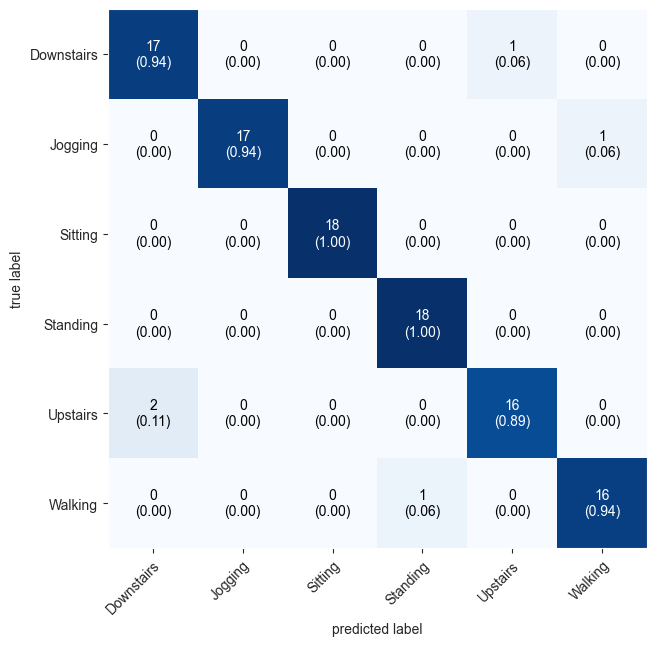

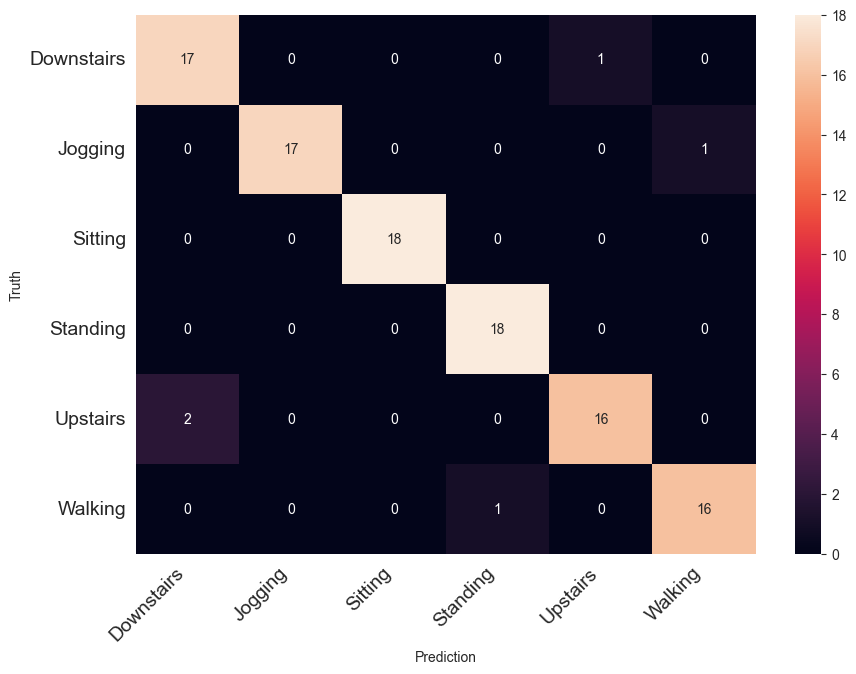

In [60]:
truth = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
prediction = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]

y_pred = np.argmax(model.predict(X_test), axis=-1)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7, 7))
plt.show()  # You also need to add this line to display the plot

print_confusion_matrix(mat, label.classes_)